In [1]:
import csv
import math

import matplotlib.pyplot as plt
import numpy as np

from keras import applications
from keras.callbacks import ModelCheckpoint
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential, Model
from keras.layers import Dropout, Flatten, Dense, Input
from keras.initializers import glorot_uniform
from keras.applications.vgg16 import preprocess_input

Using TensorFlow backend.


In [82]:
# build the VGG16 network
input_tensor = Input(shape=(224,224,3))
model = applications.VGG16(weights='imagenet', include_top=False, input_tensor = input_tensor)

In [92]:
# build a classifier model to put on top of the convolutional model
x = model.output
x = Flatten(input_shape=(model.output_shape[1:]))(x)
x = Dropout(0.2)(x)
x = Dense(300, activation='relu', kernel_initializer='glorot_normal')(x)
x = Dropout(0.2)(x)
x = Dense(300, activation='relu', kernel_initializer='glorot_normal')(x)
x = Dense(5, activation='softmax', name='output', kernel_initializer='glorot_normal')(x)

# add new classifier model on top of convolutional base
new_model = Model(model.input, x)

In [84]:
# set the first 19 layers (up to the last conv block)
# to non-trainable (weights will not be updated)
for layer in new_model.layers[:19]:
    layer.trainable = False

In [85]:
new_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [86]:
# Use SGD and Categorical CE Loss
#sgd = optimizers.SGD(lr=1e-3, decay=1e-6, momentum=0.9, nesterov=True)
#new_model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])

new_model.compile(loss='categorical_crossentropy',
                  optimizer=optimizers.Adam(lr=0.0003), metrics=['accuracy'])

# RMSprop
# new_model.compile(loss='categorical_crossentropy',
#                   optimizer=optimizers.RMSprop(lr=0.0001, rho=0.9, epsilon=1e-07, decay=0.0), metrics=['accuracy'])

In [4]:
# read the CSV into memory
prices = []
image_paths = []

data_path = "../datasets/cars_im/"
with open("../datasets/cars_classified.csv") as file:
    reader = csv.reader(file)
    i = -1
    for row in reader:
        i += 1
        index = row[0]
        name = row[1]
        msrp = row[3]
        label = row[4]
        
        image_path = data_path + index + '.jpg'
        image_paths.append(image_path)
        prices.append(str(label))

In [5]:
prices[-1]

'80'

In [6]:
def image_generator(indices, batch_size):

    num_batches = int(len(indices) / batch_size)
    
    while True:
        for batch_i in range(num_batches):
            if batch_i == num_batches - 1:
                # special case: return as many as possible
                start_i = batch_i * batch_size
                batch_indices = indices[start_i:]
                
                X = np.zeros((len(batch_indices), 224, 224, 3))
                Y = np.zeros((len(batch_indices), 5)) # Change to one-hot
            
            else:
                start_i = batch_i * batch_size
                end_i = start_i + batch_size

                batch_indices = indices[start_i:end_i]

                X = np.zeros((batch_size, 224, 224, 3))
                Y = np.zeros((batch_size, 5)) # Change to one-hot
            
            for i, index in enumerate(batch_indices):
                img = image.load_img(image_paths[index], target_size=(224, 224))
                X[i, :, :, :] = image.img_to_array(img)
                # Convert to 1 hot vector
                p = prices[index]
                if p == "20":
                    Y[i,:] = np.array([1,0,0,0,0])
                if p == "40":
                    Y[i,:] = np.array([0,1,0,0,0])
                if p == "60":
                    Y[i,:] = np.array([0,0,1,0,0])
                if p == "80":
                    Y[i,:] = np.array([0,0,0,1,0])
                if p == "100":
                    Y[i,:] = np.array([0,0,0,0,1])
            
            # use vgg16 preprocessing
            X = preprocess_input(X)
            
            yield (X, Y)

In [7]:
train_indices = np.load("cars_train_indices.npy")
test_indices = np.load("cars_test_indices.npy")
print(train_indices.shape)
print(test_indices.shape)

(1330,)
(147,)


In [91]:
epochs = 25
minibatch_size = 70

train_steps = math.ceil(len(train_indices) / minibatch_size)
test_steps = math.ceil(len(test_indices) / minibatch_size)

checkpoint = ModelCheckpoint('cars_classification_best.hdf5', monitor='val_acc', verbose=1, save_best_only=True, mode='max')

# fine-tune the model
history = new_model.fit_generator(
    image_generator(train_indices, minibatch_size),
    steps_per_epoch=train_steps,
    epochs=epochs,
    validation_data=image_generator(test_indices, minibatch_size),
    nb_val_samples=test_steps,
    callbacks=[checkpoint])
# new_model.save('cars_classification_best.hdf5')

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  app.launch_new_instance()
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., steps_per_epoch=19, epochs=25, validation_data=<generator..., callbacks=[<keras.ca..., validation_steps=3)`
  app.launch_new_instance()


Epoch 1/25
19/19 [==============================] - 21s - loss: 6.4587 - acc: 0.3549 - val_loss: 3.7953 - val_acc: 0.4839
Epoch 2/25
19/19 [==============================] - 21s - loss: 3.2224 - acc: 0.4699 - val_loss: 1.2271 - val_acc: 0.5446
Epoch 3/25
19/19 [==============================] - 21s - loss: 1.3951 - acc: 0.5188 - val_loss: 0.9803 - val_acc: 0.6313
Epoch 4/25
19/19 [==============================] - 21s - loss: 1.0565 - acc: 0.5842 - val_loss: 0.8646 - val_acc: 0.7054
Epoch 5/25
19/19 [==============================] - 20s - loss: 0.9669 - acc: 0.6105 - val_loss: 0.7698 - val_acc: 0.7051
Epoch 6/25
19/19 [==============================] - 21s - loss: 0.9092 - acc: 0.6278 - val_loss: 0.7694 - val_acc: 0.7232
Epoch 7/25
19/19 [==============================] - 21s - loss: 0.8782 - acc: 0.6489 - val_loss: 0.6752 - val_acc: 0.7235
Epoch 8/25
19/19 [==============================] - 20s - loss: 0.8321 - acc: 0.6571 - val_loss: 0.6482 - val_acc: 0.7188
Epoch 9/25
19/19 [======

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


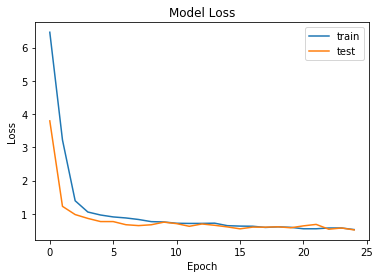

In [93]:
print(history.history.keys())
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [8]:
from keras.models import load_model
new_model = load_model('../datasets/cars_classification_best.hdf5')

In [11]:
true_label = []
predicted_label = []
for index in test_indices:
    msrp = prices[index]
    true_label.append(str(msrp))
    
    path = image_paths[index]
    img = image.load_img(path, target_size=(224, 224))
    data = np.expand_dims(image.img_to_array(img), axis=0)
    data = preprocess_input(data)
    
    # Prediction outputs softmax vector
    prediction = new_model.predict(data)
    
    # Set most confident prediction as label, and convert it to our price scale
    label = np.argmax(prediction) * 20 + 20
    predicted_label.append(str(label))

In [12]:
from sklearn.metrics import confusion_matrix, classification_report
print("Classification report:\n%s\n"
      % (classification_report(true_label, predicted_label)))
print("Confusion matrix:\n%s" % confusion_matrix(true_label, predicted_label))

Classification report:
             precision    recall  f1-score   support

        100       0.85      0.97      0.90        29
         20       0.87      0.94      0.91        36
         40       0.76      0.82      0.79        34
         60       0.81      0.52      0.63        25
         80       0.82      0.78      0.80        23

avg / total       0.82      0.82      0.82       147


Confusion matrix:
[[28  0  0  0  1]
 [ 0 34  2  0  0]
 [ 0  3 28  2  1]
 [ 2  1  7 13  2]
 [ 3  1  0  1 18]]
